In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox
import os


<Figure size 720x720 with 0 Axes>

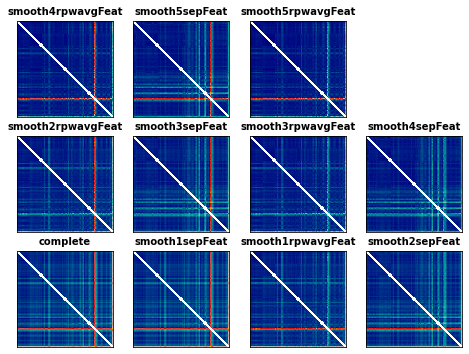

In [59]:
path = os.path.dirname(os.path.abspath('__file__'))
matlab_data = io.matlab.loadmat(
    os.path.join(path, '..', 'demos',
                 'rdms_inferring', 'modelRDMs_A2020.mat'))

matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]



measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0]
                       for i in range(n_models)])

model_rdms = rsatoolbox.rdm.RDMs(
    rdms_array,
    rdm_descriptors={'brain_computational_model': model_names,
                     'measurement_model': measurement_model},
    dissimilarity_measure='Euclidean'
    )
conv1_rdms = model_rdms.subset('brain_computational_model', 'conv1')

plt.figure(figsize=(10, 10))
rsatoolbox.vis.show_rdm(conv1_rdms,
                   rdm_descriptor='measurement_model')

None

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0


<Figure size 720x720 with 0 Axes>

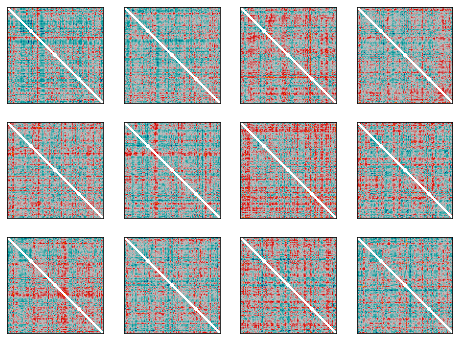

In [92]:
matlab_data = io.matlab.loadmat(
    os.path.join(path, '..', 'demos',
                 'rdms_inferring', 'noisyModelRDMs_A2020.mat'))
repr_names_matlab = matlab_data['reprNames']

fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']


repr_names = [repr_names_matlab[i][0][0]
              for i in range(repr_names_matlab.shape[0])]

fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')


i_rep = 2  # np.random.randint(len(repr_names))
i_noise = 1  # np.random.randint(len(noise_std))
i_fwhm = 0  # np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])


# put the rdms into an RDMs object and show it
rdms_data = rsatoolbox.rdm.RDMs(
    rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

plt.figure(figsize=(10, 10))
rsatoolbox.vis.show_rdm(rdms_data)
None

In [95]:
models = []

for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset(
        'brain_computational_model', i_model).subset(
            'measurement_model', 'complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)
    

In [ ]:


print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

results_1 = rsatoolbox.inference.eval_fixed(
    models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1)

results_2a = rsatoolbox.inference.eval_bootstrap_rdm(
    models, rdms_data, method='corr', N=10)
rsatoolbox.vis.plot_model_comparison(results_2a)

results_2b = rsatoolbox.inference.eval_bootstrap_pattern(
    models, rdms_data, method='corr', N=10)
rsatoolbox.vis.plot_model_comparison(results_2b)

results_2c = rsatoolbox.inference.eval_bootstrap(
    models, rdms_data, method='corr', N=10)
rsatoolbox.vis.plot_model_comparison(results_2c)

models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(rsatoolbox.model.ModelSelect(i_model,
        model_rdms.subset('brain_computational_model', i_model)))

print('created the following models:')
for i in range(len(models_flex)):
    print(models_flex[i].name)

train_set, test_set, ceil_set = rsatoolbox.inference.sets_k_fold(
    rdms_data, k_pattern=3, k_rdm=2)

results_3_cv = rsatoolbox.inference.crossval(
    models_flex, rdms_data, train_set, test_set,
    ceil_set=ceil_set, method='corr')
# plot results
rsatoolbox.vis.plot_model_comparison(results_3_cv)

results_3_full = rsatoolbox.inference.bootstrap_crossval(
    models_flex, rdms_data, k_pattern=4, k_rdm=2, method='corr', N=5)
# plot results
rsatoolbox.vis.plot_model_comparison(results_3_full)
